In [2]:
% reload_ext autoreload
% autoreload 2
% matplotlib inline
from IPython import display

import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch
from torch import nn
from torch.utils.data import DataLoader

import utils
import models

# MNIST

This notebook uses the `MNIST` dataset to illustrate the structure of code for this project in the context of the `pytorch` echosystem.

## The pytorch sequence

* **Dataset**: A `Dataset` is an object that supports indexing and length operations. `Dataset[i]` will return a tuple of the ith training instance and its label. The returned instance and label will be in a pytorch-friently format i.e. Tensors. `Dataset[i] = (x:Tensor, y: Tensor)`.

* **Dataloader**: A `Dataloader` is a wrapper around a `Dataset`. It uses multiple processes to quickly read the `Dataset` at multiple indices. It can also convert single instances into mini-batches, shuffle data etc. A `Dataloader` can be iterated over to provide training and label data ready for comsumption by the network. So `for x, y in Dataloader` will yield a Tensor containing a minibatch of training examples and their corresponding labels.

* **Module**: A `Module` is a neural network (or any differentiable function) that can accept a minibatch and output predictions.

* **Criterion**: A class that describes the loss function the `Module` will use the judge how bad its outputs are compared to the true labels. That is, `loss = criterion(prediction, labels)` will return the loss function computed for that minibatch.

* **Optimizer**: A class that describes how to update `Module` weights given the loss. It takes as arguments a reference to the `Module` parameters, and other hyperparameters like learning rate and momentum.

The standard training loop goes like:

```
Create a dataset that can return individual examples,
Give that dataset to a dataloader to generate batches,
Create network = Module(),
Create loss, optimization functions from hyperparameters,
Transfer network to GPU if required

For epoch in number of epochs:
    For x, y in dataloader:
        transfer x, y to GPU if required
        zero-out network gradients from previous iteration (optimizer.zero_grad()),
        generate outputs (predictions = network(x))
        compute loss = criterion(predictions, y)
        backpropagate loss (loss.backward())
        optimize parameters (optimizer.step())
```

## Sequence simplified

This project simplifies the sequence by encapsulating `torch` functions. The entirety of a model (from data input to training) is described by a single file in `models/`. Each model file contains:

* **Net()**: A `Module` that describes the network architecture.
* **Data()**: A `Dataset` that reads and indexes individual examples in torch-friendly format.
* **Model()**: A class that is instantiated with `net`, `optimizer`, `criterion`. It has a `train()` method that includes the training loop logic.

In [5]:
# a torch.utils.data.DataSet instance. Can be indexed to lazily
# load instance/label. Ideally all datasets should be subclassed from
# DataSet.
traindata = models.mnist.Data(root='~/Downloads/MNIST', train=True)

print('Instances: {}'.format(len(traindata)))

Instances: 60000


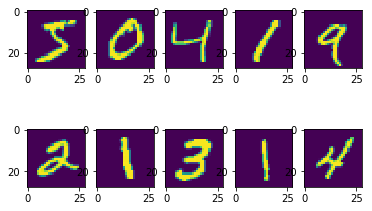

In [7]:
fig, (row1, row2) = plt.subplots(nrows=2, ncols=5)
for i, ax in enumerate((*row1, *row2)):
    x, y = traindata[i]  # x.shape == (1, 28, 28), y.shape == (1,)
    ax.imshow(x[0])

In [10]:
# Define hyperparameters
EPOCHS = 1
BATCH_SIZE = 10
LRATE = 1e-3
MOMENTUM = 0.9
USE_CUDA = True

# Instantiate the defined network and hyperparameters
net = models.mnist.Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=LRATE, momentum=MOMENTUM)

# Create a model that combines it all.
model = models.mnist.Model(net=net, criterion=criterion, optimizer=optimizer, cuda=USE_CUDA)

# Train model with verbal updates
model.train(dataset=traindata, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch # 0
Min-batch # 1000	 Loss: 1.387
Min-batch # 2000	 Loss: 0.451
Min-batch # 3000	 Loss: 0.360
Min-batch # 4000	 Loss: 0.350
Min-batch # 5000	 Loss: 0.333
Min-batch # 6000	 Loss: 0.252


In [92]:
# Evaluate on test set
testdata = models.mnist.Data(root='~/Downloads/MNIST', train=False)
testloader = DataLoader(testdata, batch_size=BATCH_SIZE)

total = len(testdata)
correct = 0
for batchX, batchY in testloader:
    batchX, batchY = batchX.to(DEVICE), batchY.to(DEVICE)
    _, pred = torch.max(net(batchX), 1)
    correct += (pred == batchY).sum().item()

print('Accuracy: {:.2f}%'.format(100 * correct / total))

Accuracy: 93.39%
